# Heartbeat Prediction


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gc
from colorama import Fore, Style
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

cuda_NO = 1
with_SMOTE = True
if_train = True
fix_rand_seed = 1
rand_seed = 37
num_epochs = 100
batch_size = 256
model_save_path = "best_heartbeat_model.pth"

print(torch.cuda.is_available())
device = f"cuda:{cuda_NO}" if torch.cuda.is_available() else "cpu"
print(device)

!nvidia-smi

True
cuda:1
Tue Dec  3 03:54:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:AF:00.0 Off |                  N/A |
| 30%   23C    P8              25W / 350W |  12458MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------------

# Preprocessing

## Set random seed

In [16]:
def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if fix_rand_seed:
    set_rand_seed(rand_seed)

## Read data

In [17]:
train_data = pd.read_csv('train.csv', header=0)

## Check data

In [18]:
# check the data and labels
print(train_data.head())
print(f"labels contain: {train_data['label'].unique()}")

   id                                  heartbeat_signals  label
0   0  0.9912297987616655,0.9435330436439665,0.764677...    0.0
1   1  0.9714822034884503,0.9289687459588268,0.572932...    0.0
2   2  1.0,0.9591487564065292,0.7013782792997189,0.23...    2.0
3   3  0.9757952826275774,0.9340884687738161,0.659636...    0.0
4   4  0.0,0.055816398940721094,0.26129357194994196,0...    2.0
labels contain: [0. 2. 3. 1.]


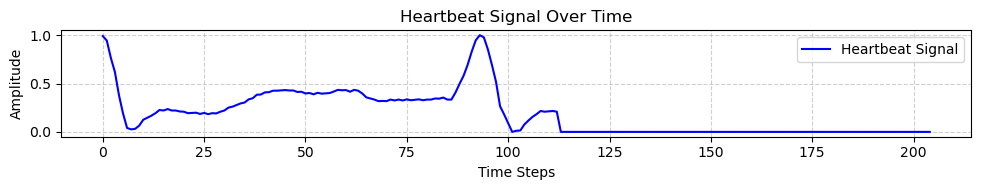

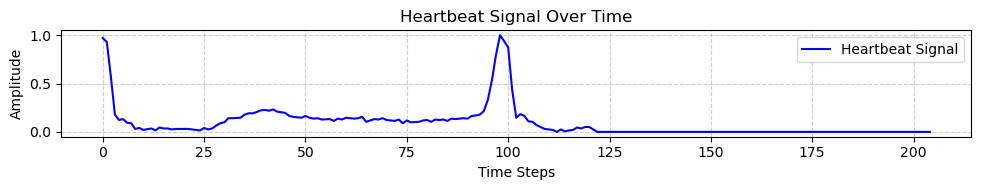

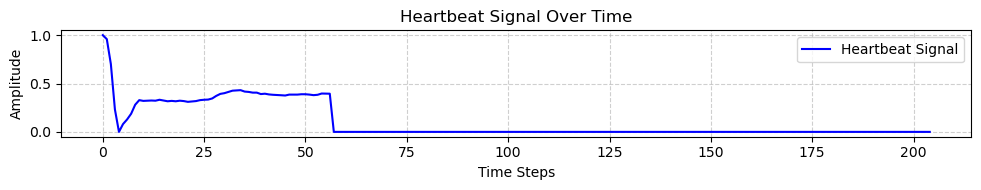

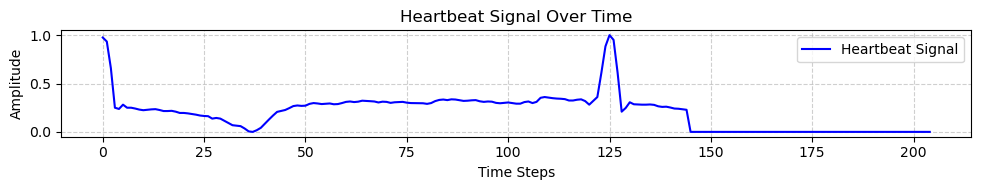

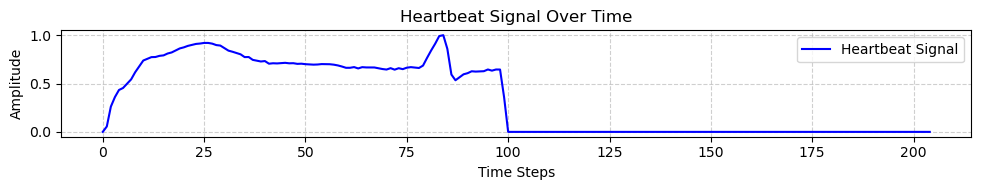

In [19]:
def plot_signal(sample_index):
    heartbeat_signal = train_data['heartbeat_signals'].iloc[sample_index]
    vector = list(map(float, heartbeat_signal.split(',')))

    plt.figure(figsize=(10, 2))
    plt.plot(vector, label="Heartbeat Signal", color='blue')
    plt.title("Heartbeat Signal Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.grid(linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

for i in range(5):
    plot_signal(i)

## Preprocessing functions

In [20]:
# normalization
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def to_array(signal):
    return np.array(list(map(float, signal.split(','))))

# preprocessing
def preprocess_signal(signal):
    signal = to_array(signal) # this comes first!
    # data is already normalized
    return signal

## Split with SMOTE

In [21]:
if with_SMOTE:
    X = train_data['heartbeat_signals']
    y = train_data['label']

    X = X.apply(preprocess_signal)
    y = y.apply(lambda x: int(x))

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=rand_seed)

    # SMOTE, to vector
    X_train_flat = np.array([x.flatten() for x in X_train])
    y_train = y_train.values

    smote = SMOTE(random_state=rand_seed)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)

    # recover data to tensor
    X_train_balanced = [np.reshape(x, (-1,)) for x in X_train_balanced]

    # reset index
    X_val = X_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

## Split without SMOTE

In [22]:
#if not with_SMOTE:
if not with_SMOTE:
    X = train_data['heartbeat_signals']
    y = train_data['label']

    X = X.apply(preprocess_signal)
    y = y.apply(lambda x: int(x))

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=rand_seed)

    # reset index
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_val = X_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

## Data Distribution

Category Distribution Before Balancing:
       Count  Percentage(%)
label                      
0.0    64327         64.327
3.0    17912         17.912
2.0    14199         14.199
1.0     3562          3.562


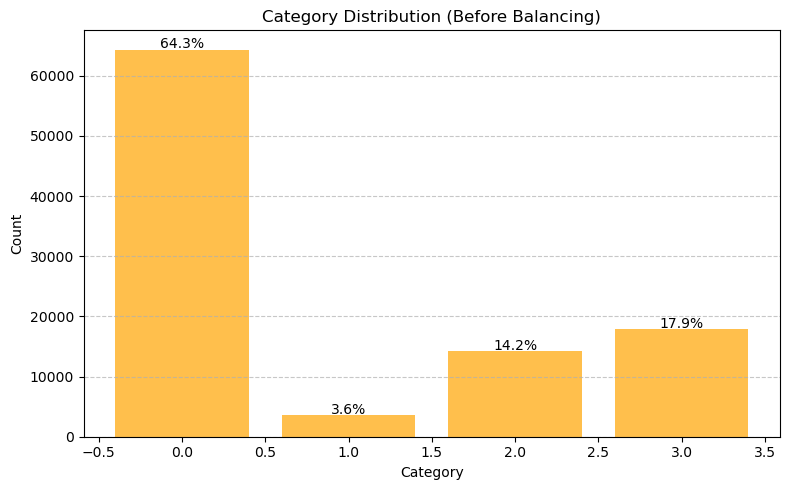

Category Distribution After Balancing:
   Count  Percentage(%)
0  64327           25.0
2  64327           25.0
3  64327           25.0
1  64327           25.0


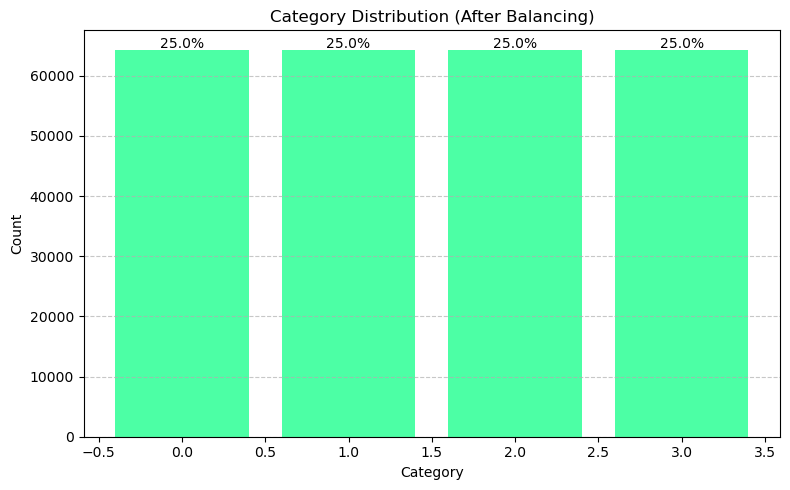

In [23]:
# original data distribution
category_counts_original = train_data['label'].value_counts()
category_percentages_original = category_counts_original / len(train_data) * 100
category_distribution_original = pd.DataFrame({
    'Count': category_counts_original,
    'Percentage(%)': category_percentages_original
})
print("Category Distribution Before Balancing:")
print(category_distribution_original)

# original data visualization
plt.figure(figsize=(8, 5))
plt.bar(category_counts_original.index, category_counts_original.values, alpha=0.7, color='orange')
for idx, val in category_counts_original.items():
    plt.text(idx, val + 200, f"{category_percentages_original[idx]:.1f}%", ha='center')
plt.title('Category Distribution (Before Balancing)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# SMOTE
X_flat = np.array([x.flatten() for x in X])
y = y.values
smote = SMOTE(random_state=rand_seed)
X_balanced, y_balanced = smote.fit_resample(X_flat, y)

# data distribution after SMOTE
category_counts_balanced = pd.Series(y_balanced).value_counts()
category_percentages_balanced = category_counts_balanced / len(y_balanced) * 100
category_distribution_balanced = pd.DataFrame({
    'Count': category_counts_balanced,
    'Percentage(%)': category_percentages_balanced
})
print("Category Distribution After Balancing:")
print(category_distribution_balanced)

# data visualization after SMOTE
plt.figure(figsize=(8, 5))
plt.bar(category_counts_balanced.index, category_counts_balanced.values, alpha=0.7, color='springgreen')
for idx, val in category_counts_balanced.items():
    plt.text(idx, val + 200, f"{category_percentages_balanced[idx]:.1f}%", ha='center')
plt.title('Category Distribution (After Balancing)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and dataloader

In [24]:
class HeartbeatDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        signal = self.data[index]
        label = self.labels[index]
        # Convert to pytorch tensor, set to float32
        signal = torch.tensor(signal, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)  # Classification labels should be long
        return signal, label
    
if with_SMOTE:
    train_dataset = HeartbeatDataset(X_train_balanced, y_train_balanced)
else:
    train_dataset = HeartbeatDataset(X_train, y_train)
val_dataset = HeartbeatDataset(X_val, y_val)
test_dataset = HeartbeatDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model definition, training and prediction

## Model
We build the classification model based on several famous networks, and added our own adjustment to make use of the task's features.
- CNN: extract local feature.
- RNN(LSTM): make use of the feature in time dimension.
- Attention based networks: 捕捉长距离特征，自动关注对模型当前最重要的部分，同时使用multi-head attention。

In [25]:
class HeartbeatModel(nn.Module):
    def __init__(self, input_size, num_classes, num_layers, dropout):
        super(HeartbeatModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            #nn.Dropout(p=dropout),

            #nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            #nn.Dropout(p=dropout),

            #nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            #nn.Dropout(p=dropout),
        )
        self.rnn = nn.LSTM(input_size=32, hidden_size=64, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=64*2, num_heads=4, batch_first=True)
        #self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64*2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x, _ = self.rnn(x)
        x, _ = self.attention(x, x, x)
        #x = self.dropout(x)
        x = x.mean(dim=1)
        return self.fc(x)

## Training

In [26]:

# clean gpu cache
gc.collect()
torch.cuda.empty_cache()

# hyper
num_classes = 4
input_dim = 205  # max length of the signal
hidden_dim = 128
output_dim = num_classes
num_layers = 1 # for rnn
dropout = 0.3
lr = 5e-4

criterion = nn.CrossEntropyLoss()

model = HeartbeatModel(input_size=input_dim, num_classes=output_dim, num_layers=num_layers, dropout=dropout)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
total_steps = len(train_loader) * num_epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    if not if_train:
        return None
    
    model.to(device)
    best_accuracy = 0.0
    
    # save info for visualization
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_epochs = [] # record the epoch when the model is saved

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0

        # training
        for batch in tqdm(train_loader, desc=f"Training"):
            signals, labels = batch
            signals, labels = signals.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        # record train loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validating"):
                signals, labels = batch
                signals, labels = signals.to(device), labels.to(device)

                outputs = model(signals)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, pred = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        
        # record train loss and acc
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(Fore.GREEN + f"Saved best model with accuracy: {best_accuracy:.4f}" + Style.RESET_ALL)
            best_epochs.append(epoch + 1)
            
        print()
        
    return train_losses, val_losses, val_accuracies, best_epochs


# Training
train_losses, val_losses, val_accuracies, best_epochs = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 104.29it/s]


Train Loss: 0.5731, Val Loss: 0.2844, Val Accuracy: 0.9035
Saved best model with accuracy: 0.9035

Epoch 2/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.29it/s]


Train Loss: 0.1904, Val Loss: 0.2647, Val Accuracy: 0.9116
Saved best model with accuracy: 0.9116

Epoch 3/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.89it/s]


Train Loss: 0.1281, Val Loss: 0.1698, Val Accuracy: 0.9425
Saved best model with accuracy: 0.9425

Epoch 4/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 123.59it/s]


Train Loss: 0.1028, Val Loss: 0.1478, Val Accuracy: 0.9491
Saved best model with accuracy: 0.9491

Epoch 5/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 114.21it/s]


Train Loss: 0.0873, Val Loss: 0.1051, Val Accuracy: 0.9645
Saved best model with accuracy: 0.9645

Epoch 6/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.16it/s]


Train Loss: 0.0743, Val Loss: 0.0878, Val Accuracy: 0.9734
Saved best model with accuracy: 0.9734

Epoch 7/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.63it/s]


Train Loss: 0.0657, Val Loss: 0.1178, Val Accuracy: 0.9607

Epoch 8/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.56it/s]


Train Loss: 0.0582, Val Loss: 0.0965, Val Accuracy: 0.9692

Epoch 9/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 112.58it/s]


Train Loss: 0.0516, Val Loss: 0.0931, Val Accuracy: 0.9718

Epoch 10/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 100.74it/s]


Train Loss: 0.0482, Val Loss: 0.0776, Val Accuracy: 0.9753
Saved best model with accuracy: 0.9753

Epoch 11/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 118.11it/s]


Train Loss: 0.0421, Val Loss: 0.0700, Val Accuracy: 0.9800
Saved best model with accuracy: 0.9800

Epoch 12/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 96.17it/s]


Train Loss: 0.0389, Val Loss: 0.1010, Val Accuracy: 0.9680

Epoch 13/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 114.92it/s]


Train Loss: 0.0357, Val Loss: 0.0856, Val Accuracy: 0.9720

Epoch 14/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.39it/s]


Train Loss: 0.0344, Val Loss: 0.0825, Val Accuracy: 0.9738

Epoch 15/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.23it/s]


Train Loss: 0.0309, Val Loss: 0.0670, Val Accuracy: 0.9795

Epoch 16/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.94it/s]


Train Loss: 0.0287, Val Loss: 0.0727, Val Accuracy: 0.9777

Epoch 17/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.60it/s]


Train Loss: 0.0268, Val Loss: 0.0660, Val Accuracy: 0.9800

Epoch 18/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 120.51it/s]


Train Loss: 0.0261, Val Loss: 0.0499, Val Accuracy: 0.9863
Saved best model with accuracy: 0.9863

Epoch 19/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 96.52it/s]


Train Loss: 0.0238, Val Loss: 0.0566, Val Accuracy: 0.9838

Epoch 20/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.79it/s]


Train Loss: 0.0226, Val Loss: 0.0797, Val Accuracy: 0.9756

Epoch 21/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 118.89it/s]


Train Loss: 0.0220, Val Loss: 0.0723, Val Accuracy: 0.9782

Epoch 22/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 120.68it/s]


Train Loss: 0.0198, Val Loss: 0.0599, Val Accuracy: 0.9822

Epoch 23/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 120.16it/s]


Train Loss: 0.0190, Val Loss: 0.0578, Val Accuracy: 0.9828

Epoch 24/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 104.51it/s]


Train Loss: 0.0184, Val Loss: 0.0574, Val Accuracy: 0.9840

Epoch 25/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 114.82it/s]


Train Loss: 0.0172, Val Loss: 0.0681, Val Accuracy: 0.9800

Epoch 26/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 120.29it/s]


Train Loss: 0.0164, Val Loss: 0.0587, Val Accuracy: 0.9831

Epoch 27/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.23it/s]


Train Loss: 0.0150, Val Loss: 0.0825, Val Accuracy: 0.9763

Epoch 28/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.93it/s]


Train Loss: 0.0138, Val Loss: 0.0691, Val Accuracy: 0.9812

Epoch 29/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 119.91it/s]


Train Loss: 0.0140, Val Loss: 0.0557, Val Accuracy: 0.9863

Epoch 30/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 118.08it/s]


Train Loss: 0.0126, Val Loss: 0.0532, Val Accuracy: 0.9856

Epoch 31/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.87it/s]


Train Loss: 0.0129, Val Loss: 0.0494, Val Accuracy: 0.9865
Saved best model with accuracy: 0.9865

Epoch 32/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 106.14it/s]


Train Loss: 0.0114, Val Loss: 0.0595, Val Accuracy: 0.9858

Epoch 33/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 98.16it/s]


Train Loss: 0.0113, Val Loss: 0.0519, Val Accuracy: 0.9875
Saved best model with accuracy: 0.9875

Epoch 34/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.95it/s]


Train Loss: 0.0104, Val Loss: 0.0764, Val Accuracy: 0.9840

Epoch 35/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 124.75it/s]


Train Loss: 0.0101, Val Loss: 0.0560, Val Accuracy: 0.9872

Epoch 36/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.18it/s]


Train Loss: 0.0098, Val Loss: 0.0582, Val Accuracy: 0.9856

Epoch 37/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.59it/s]


Train Loss: 0.0083, Val Loss: 0.0566, Val Accuracy: 0.9880
Saved best model with accuracy: 0.9880

Epoch 38/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.53it/s]


Train Loss: 0.0088, Val Loss: 0.0562, Val Accuracy: 0.9868

Epoch 39/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 119.85it/s]


Train Loss: 0.0081, Val Loss: 0.0552, Val Accuracy: 0.9881
Saved best model with accuracy: 0.9881

Epoch 40/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.10it/s]


Train Loss: 0.0075, Val Loss: 0.0534, Val Accuracy: 0.9887
Saved best model with accuracy: 0.9887

Epoch 41/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 124.07it/s]


Train Loss: 0.0076, Val Loss: 0.0478, Val Accuracy: 0.9900
Saved best model with accuracy: 0.9900

Epoch 42/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.99it/s]


Train Loss: 0.0065, Val Loss: 0.0652, Val Accuracy: 0.9877

Epoch 43/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 84.60it/s] 


Train Loss: 0.0072, Val Loss: 0.0536, Val Accuracy: 0.9879

Epoch 44/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.80it/s]


Train Loss: 0.0067, Val Loss: 0.0528, Val Accuracy: 0.9892

Epoch 45/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 126.56it/s]


Train Loss: 0.0057, Val Loss: 0.0608, Val Accuracy: 0.9866

Epoch 46/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.35it/s]


Train Loss: 0.0054, Val Loss: 0.0579, Val Accuracy: 0.9884

Epoch 47/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 85.72it/s]


Train Loss: 0.0055, Val Loss: 0.0578, Val Accuracy: 0.9892

Epoch 48/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 83.10it/s]


Train Loss: 0.0045, Val Loss: 0.0627, Val Accuracy: 0.9870

Epoch 49/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 127.12it/s]


Train Loss: 0.0044, Val Loss: 0.0721, Val Accuracy: 0.9844

Epoch 50/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 118.05it/s]


Train Loss: 0.0050, Val Loss: 0.0849, Val Accuracy: 0.9842

Epoch 51/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 94.93it/s]


Train Loss: 0.0045, Val Loss: 0.0626, Val Accuracy: 0.9881

Epoch 52/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 96.36it/s]


Train Loss: 0.0035, Val Loss: 0.0649, Val Accuracy: 0.9863

Epoch 53/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 120.27it/s]


Train Loss: 0.0040, Val Loss: 0.0653, Val Accuracy: 0.9885

Epoch 54/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 91.94it/s] 


Train Loss: 0.0030, Val Loss: 0.0667, Val Accuracy: 0.9883

Epoch 55/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 119.86it/s]


Train Loss: 0.0029, Val Loss: 0.0696, Val Accuracy: 0.9878

Epoch 56/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 118.78it/s]


Train Loss: 0.0027, Val Loss: 0.0647, Val Accuracy: 0.9889

Epoch 57/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.04it/s]


Train Loss: 0.0030, Val Loss: 0.0674, Val Accuracy: 0.9886

Epoch 58/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.10it/s]


Train Loss: 0.0024, Val Loss: 0.0669, Val Accuracy: 0.9883

Epoch 59/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.00it/s]


Train Loss: 0.0030, Val Loss: 0.0708, Val Accuracy: 0.9881

Epoch 60/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 103.19it/s]


Train Loss: 0.0012, Val Loss: 0.0681, Val Accuracy: 0.9900

Epoch 61/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.27it/s]


Train Loss: 0.0022, Val Loss: 0.0718, Val Accuracy: 0.9894

Epoch 62/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 88.91it/s]


Train Loss: 0.0021, Val Loss: 0.0712, Val Accuracy: 0.9886

Epoch 63/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.10it/s]


Train Loss: 0.0022, Val Loss: 0.0662, Val Accuracy: 0.9898

Epoch 64/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.59it/s]


Train Loss: 0.0016, Val Loss: 0.0715, Val Accuracy: 0.9892

Epoch 65/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.94it/s]


Train Loss: 0.0011, Val Loss: 0.0713, Val Accuracy: 0.9901
Saved best model with accuracy: 0.9901

Epoch 66/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.97it/s]


Train Loss: 0.0009, Val Loss: 0.0729, Val Accuracy: 0.9895

Epoch 67/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.74it/s]


Train Loss: 0.0013, Val Loss: 0.0729, Val Accuracy: 0.9896

Epoch 68/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.32it/s]


Train Loss: 0.0012, Val Loss: 0.0727, Val Accuracy: 0.9897

Epoch 69/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 99.86it/s]


Train Loss: 0.0004, Val Loss: 0.0735, Val Accuracy: 0.9907
Saved best model with accuracy: 0.9907

Epoch 70/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 116.29it/s]


Train Loss: 0.0007, Val Loss: 0.0792, Val Accuracy: 0.9893

Epoch 71/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.36it/s]


Train Loss: 0.0010, Val Loss: 0.0780, Val Accuracy: 0.9886

Epoch 72/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 97.93it/s]


Train Loss: 0.0005, Val Loss: 0.0818, Val Accuracy: 0.9880

Epoch 73/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 118.95it/s]


Train Loss: 0.0006, Val Loss: 0.0780, Val Accuracy: 0.9902

Epoch 74/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 113.45it/s]


Train Loss: 0.0003, Val Loss: 0.0800, Val Accuracy: 0.9908
Saved best model with accuracy: 0.9908

Epoch 75/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.38it/s]


Train Loss: 0.0003, Val Loss: 0.0797, Val Accuracy: 0.9901

Epoch 76/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 114.67it/s]


Train Loss: 0.0005, Val Loss: 0.0860, Val Accuracy: 0.9905

Epoch 77/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 120.02it/s]


Train Loss: 0.0003, Val Loss: 0.0823, Val Accuracy: 0.9901

Epoch 78/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.13it/s]


Train Loss: 0.0001, Val Loss: 0.0819, Val Accuracy: 0.9898

Epoch 79/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.04it/s]


Train Loss: 0.0003, Val Loss: 0.0835, Val Accuracy: 0.9905

Epoch 80/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.62it/s]


Train Loss: 0.0001, Val Loss: 0.0827, Val Accuracy: 0.9894

Epoch 81/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 103.25it/s]


Train Loss: 0.0003, Val Loss: 0.0843, Val Accuracy: 0.9900

Epoch 82/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.95it/s]


Train Loss: 0.0001, Val Loss: 0.0845, Val Accuracy: 0.9900

Epoch 83/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.28it/s]


Train Loss: 0.0001, Val Loss: 0.0845, Val Accuracy: 0.9907

Epoch 84/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 100.26it/s]


Train Loss: 0.0001, Val Loss: 0.0841, Val Accuracy: 0.9902

Epoch 85/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 119.27it/s]


Train Loss: 0.0001, Val Loss: 0.0860, Val Accuracy: 0.9901

Epoch 86/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 118.62it/s]


Train Loss: 0.0000, Val Loss: 0.0861, Val Accuracy: 0.9902

Epoch 87/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 119.41it/s]


Train Loss: 0.0000, Val Loss: 0.0880, Val Accuracy: 0.9900

Epoch 88/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 122.00it/s]


Train Loss: 0.0000, Val Loss: 0.0882, Val Accuracy: 0.9904

Epoch 89/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.81it/s]


Train Loss: 0.0000, Val Loss: 0.0896, Val Accuracy: 0.9901

Epoch 90/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.86it/s]


Train Loss: 0.0000, Val Loss: 0.0890, Val Accuracy: 0.9905

Epoch 91/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 83.06it/s] 


Train Loss: 0.0000, Val Loss: 0.0909, Val Accuracy: 0.9900

Epoch 92/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.59it/s]


Train Loss: 0.0000, Val Loss: 0.0907, Val Accuracy: 0.9901

Epoch 93/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.98it/s]


Train Loss: 0.0000, Val Loss: 0.0914, Val Accuracy: 0.9901

Epoch 94/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 107.47it/s]


Train Loss: 0.0000, Val Loss: 0.0920, Val Accuracy: 0.9902

Epoch 95/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 101.79it/s]


Train Loss: 0.0000, Val Loss: 0.0924, Val Accuracy: 0.9902

Epoch 96/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 103.54it/s]


Train Loss: 0.0000, Val Loss: 0.0924, Val Accuracy: 0.9902

Epoch 97/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 100.46it/s]


Train Loss: 0.0000, Val Loss: 0.0927, Val Accuracy: 0.9902

Epoch 98/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.57it/s]


Train Loss: 0.0000, Val Loss: 0.0926, Val Accuracy: 0.9902

Epoch 99/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 114.14it/s]


Train Loss: 0.0000, Val Loss: 0.0927, Val Accuracy: 0.9902

Epoch 100/100


Validating: 100%|██████████| 40/40 [00:00<00:00, 121.81it/s]

Train Loss: 0.0000, Val Loss: 0.0927, Val Accuracy: 0.9902



## Visualization

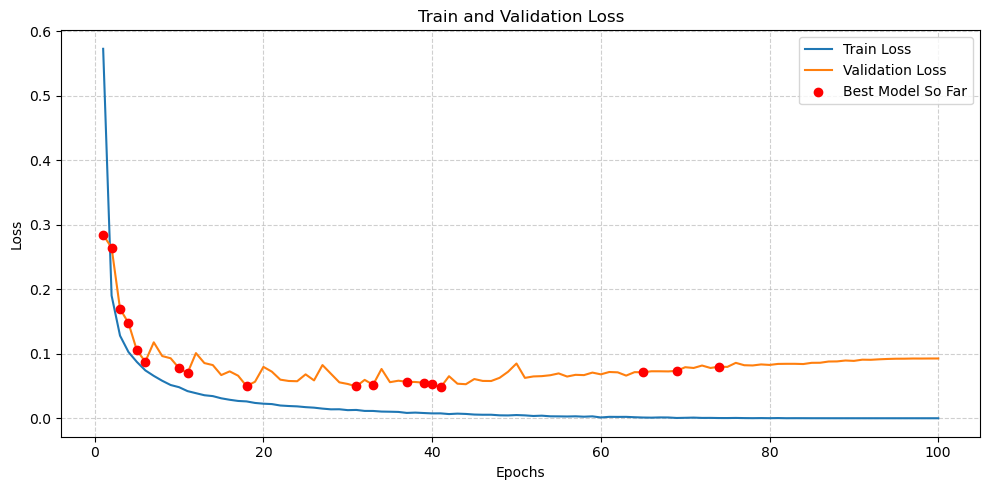

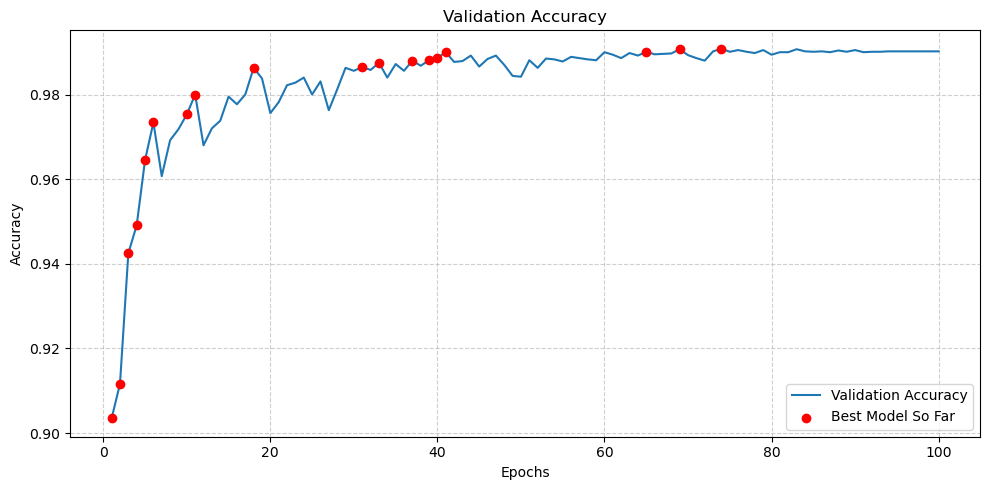

In [27]:
if if_train:
    # x-axis
    epochs = range(1, num_epochs + 1)

    # train and val loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.scatter(best_epochs, [val_losses[epoch-1] for epoch in best_epochs], 
                color='red', label="Best Model So Far", zorder=5)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # val accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.scatter(best_epochs, [val_accuracies[epoch-1] for epoch in best_epochs], 
                color='red', label="Best Model So Far", zorder=5)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

## Prediction

In [28]:
model = HeartbeatModel(input_dim, num_classes, num_layers, dropout)
model.load_state_dict(torch.load("best_heartbeat_model.pth"))
model.to(device)

def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    abs_sum_total = 0.0
    sample_num = 0

    with torch.no_grad():
        for batch in test_loader:
            signals, labels = batch
            signals, labels = signals.to(device), labels.to(device)

            outputs = model(signals) # outputs before softmax
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # One-hot of true label
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

            # abs-sum
            abs_sum_batch = torch.sum(torch.abs(labels_one_hot - probs))
            abs_sum_total += abs_sum_batch.item()
            sample_num += labels.size(0)

    abs_sum_avg = abs_sum_total / sample_num
    abs_sum = abs_sum_avg * 20000 # simulate sample.csv
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    print(f'Average abs-sum: {abs_sum_avg:.4f}')
    print(f'Total abs-sum: {abs_sum:.1f}')

test_model(model, test_loader, criterion)

/tmp/ipykernel_1907845/1477287630.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_heartbeat_model.pth"))


Test Loss: 0.0848
Test Accuracy: 98.99%
Average abs-sum: 0.0205
Total abs-sum: 410.2
